#### 부트스트래핑(bootstrapping)

In [2]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True, random_state=0)
coef

array(42.38550486)

In [3]:
dfX0 = pd.DataFrame(X0, columns=['X1'])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=['y'])

model = sm.OLS(dfy, dfX)
result = model.fit()

In [4]:
result.params

const    -1.628364
X1       42.853356
dtype: float64

In [6]:
%%time
N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_w0[i] = r.params.const
    params_w1[i] = r.params.X1

Wall time: 2.34 s


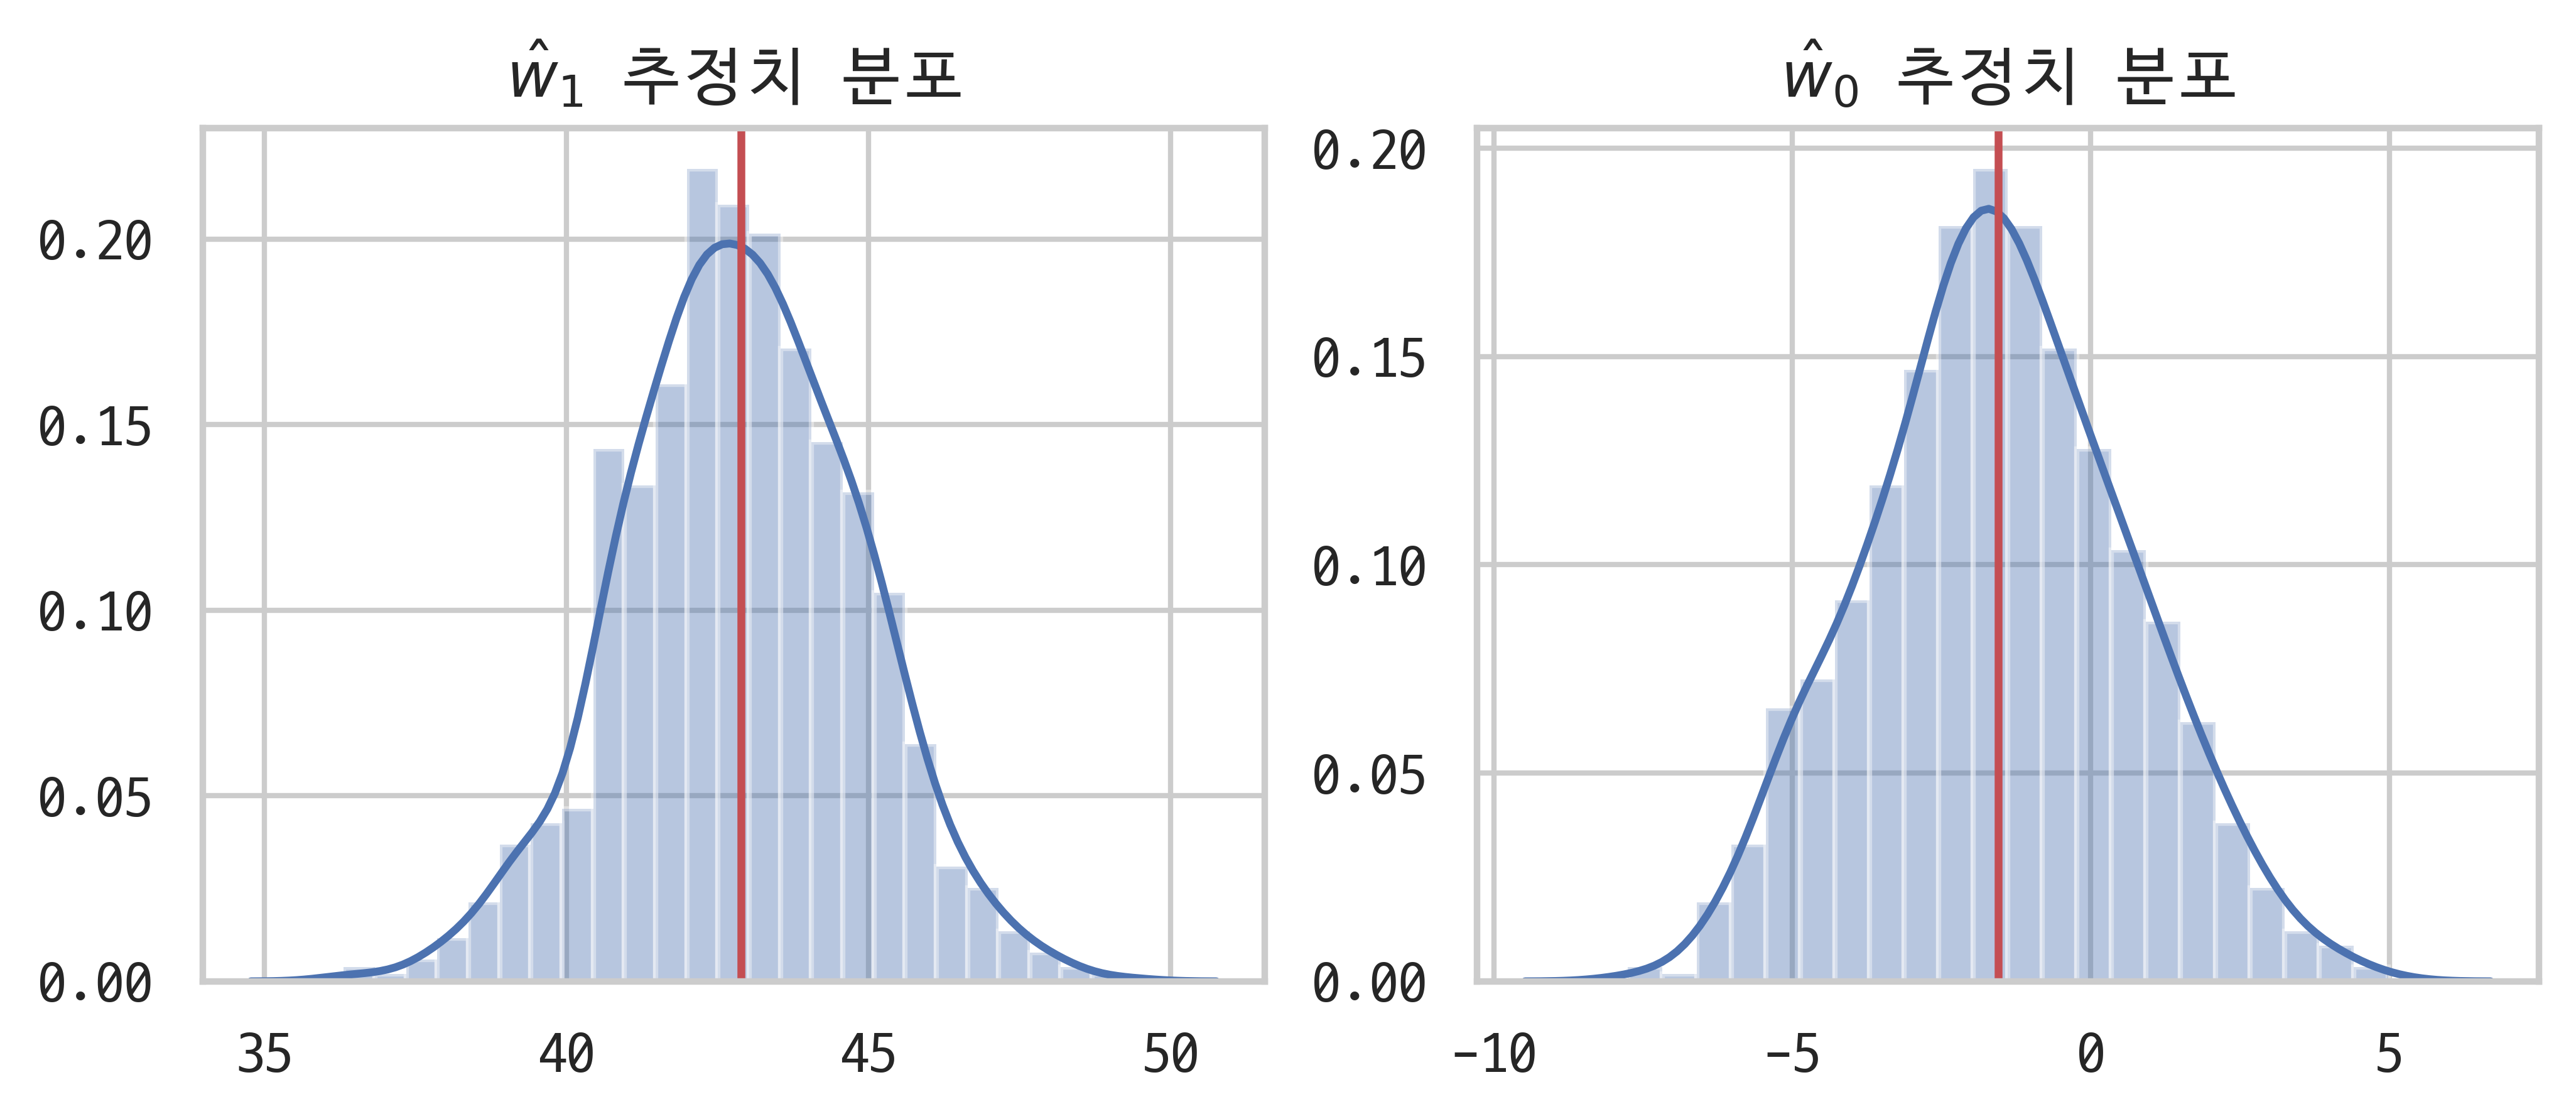

In [11]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_w1, ax=ax1)
plt.axvline(params_w1.mean(), c='r')
plt.title("$\hat{w}_1$ 추정치 분포")

ax2 = plt.subplot(122)
sns.distplot(params_w0, ax=ax2)
plt.axvline(params_w0.mean(), c='r')
plt.title("$\hat{w}_0$ 추정치 분포")
plt.show()

In [12]:
params_w1.mean(), params_w1.std()

(42.886318212938946, 1.9368113431747678)

In [13]:
params_w0.mean(), params_w0.std()

(-1.5480159903764839, 2.160616726589825)

In [14]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           2.21e-36
Time:                        17:19:05   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

#### 잔차의 분포

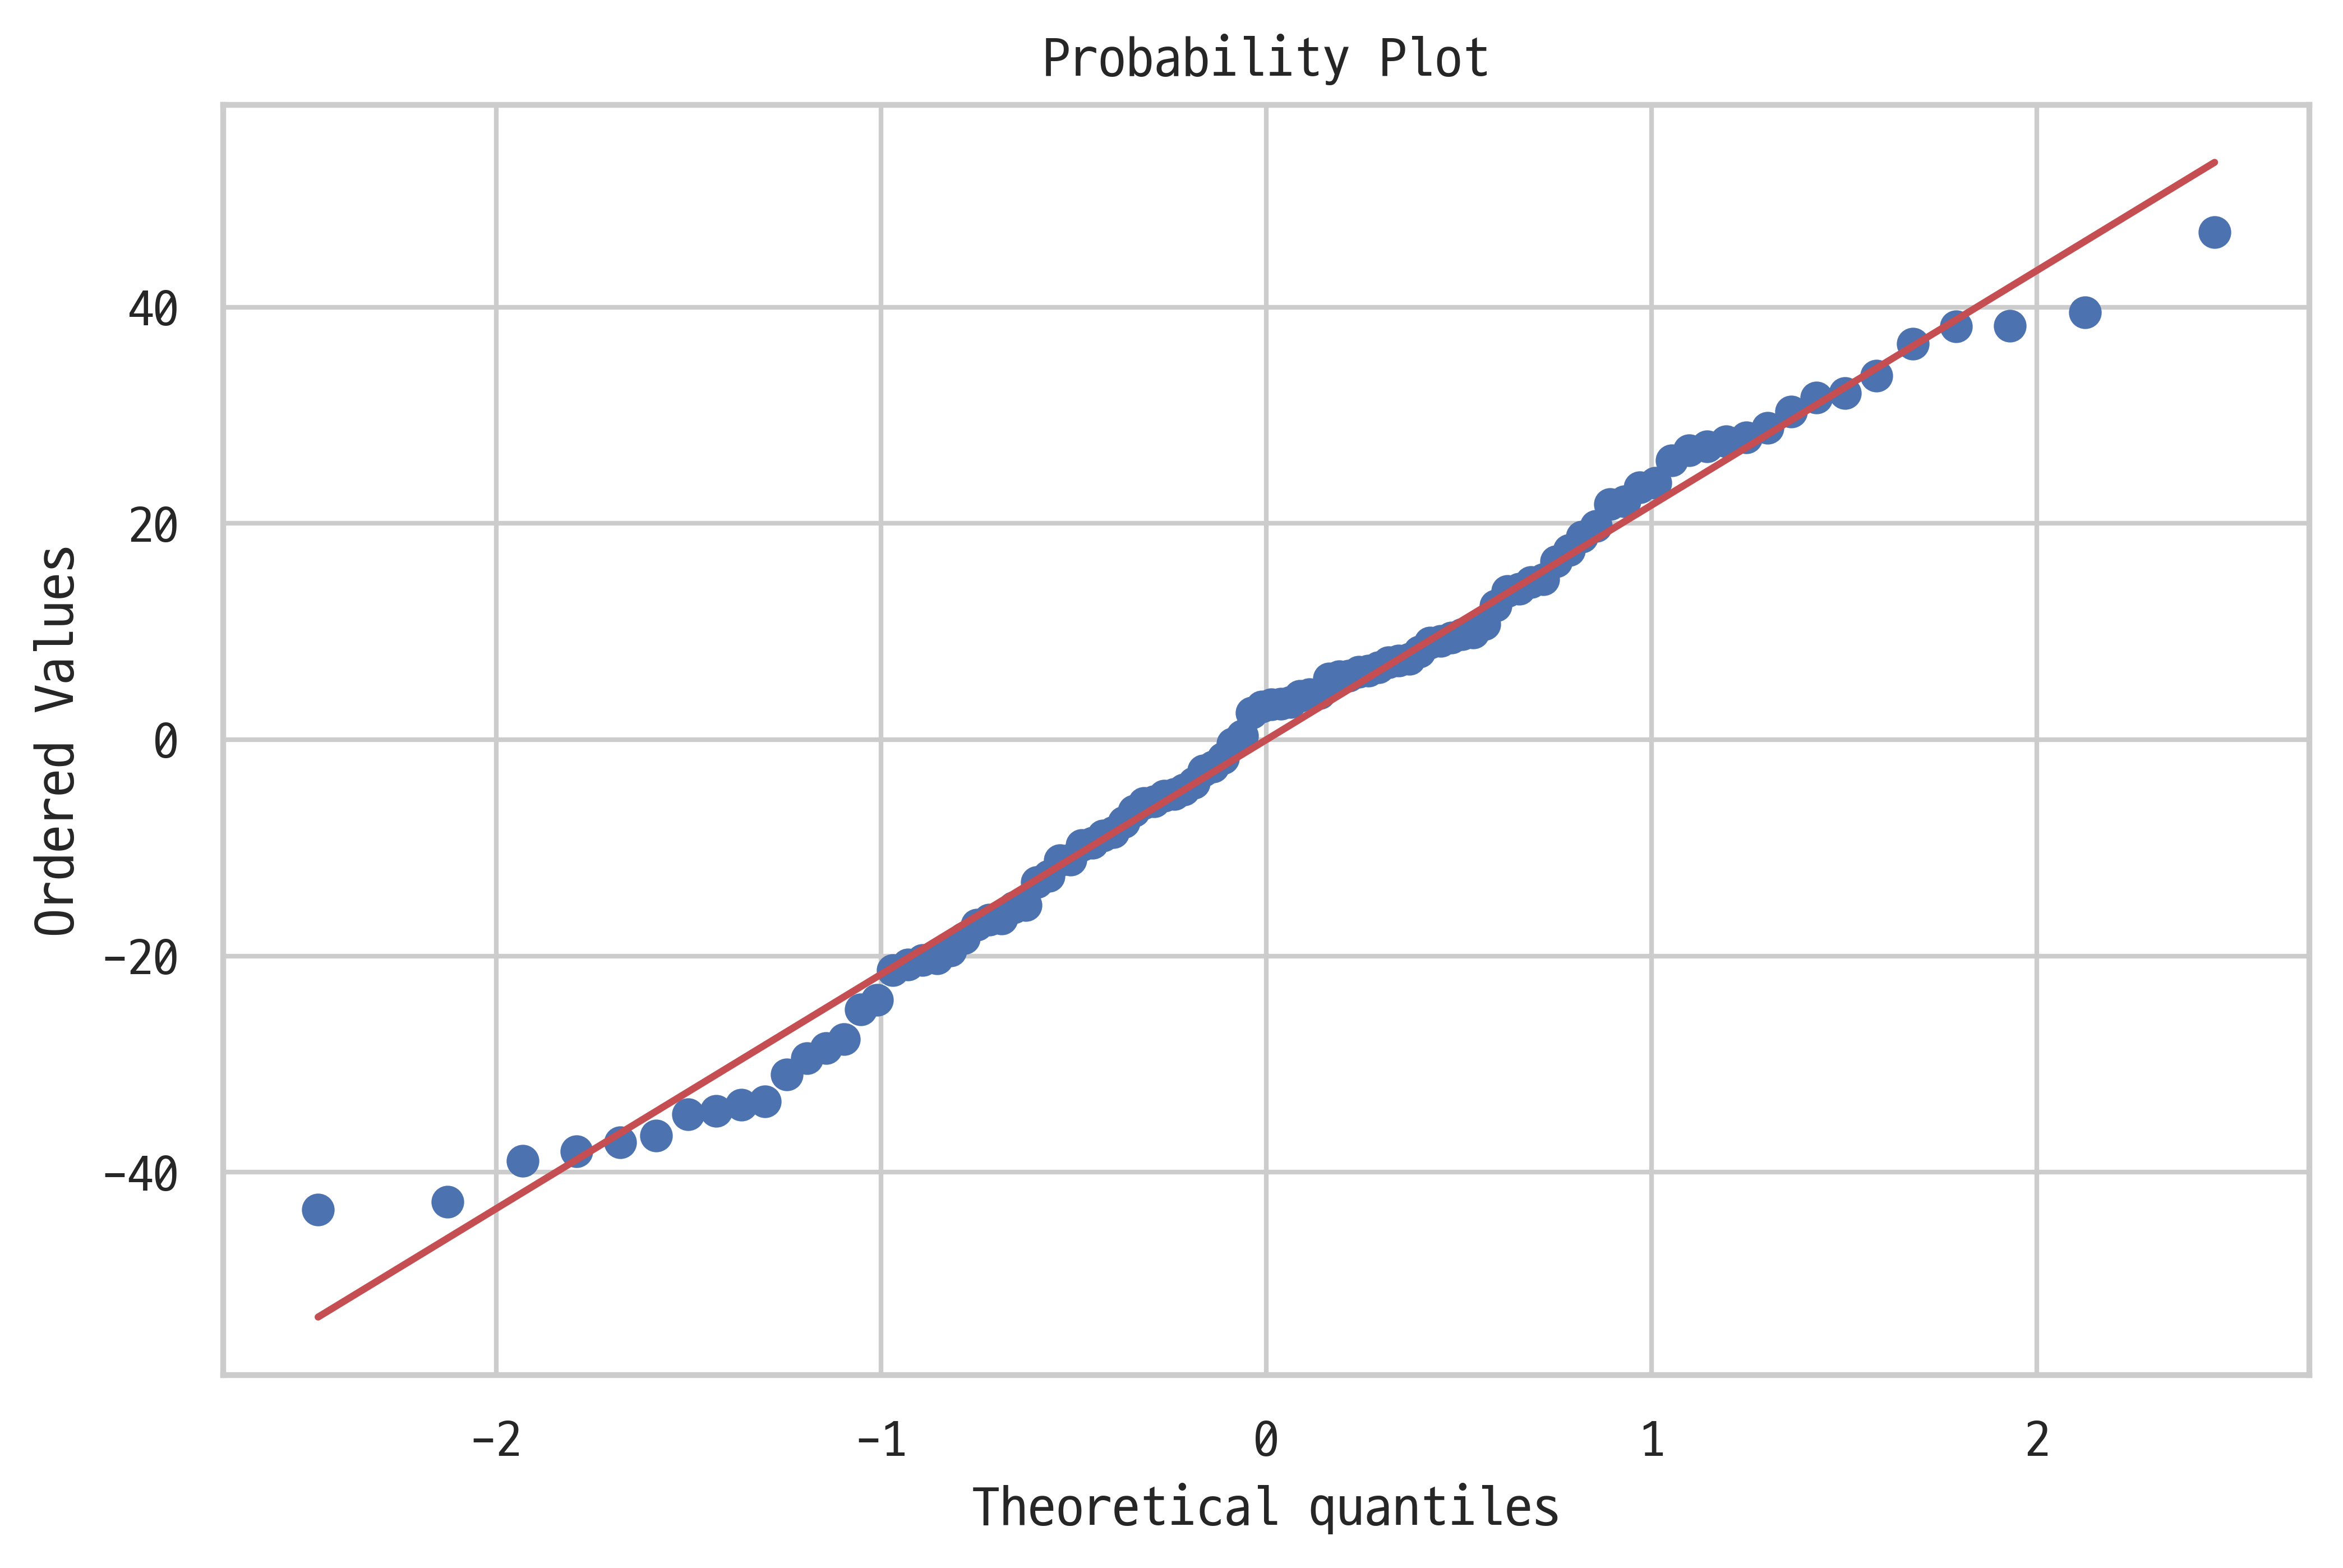

In [15]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [16]:
test = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [19]:
test = sm.stats.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


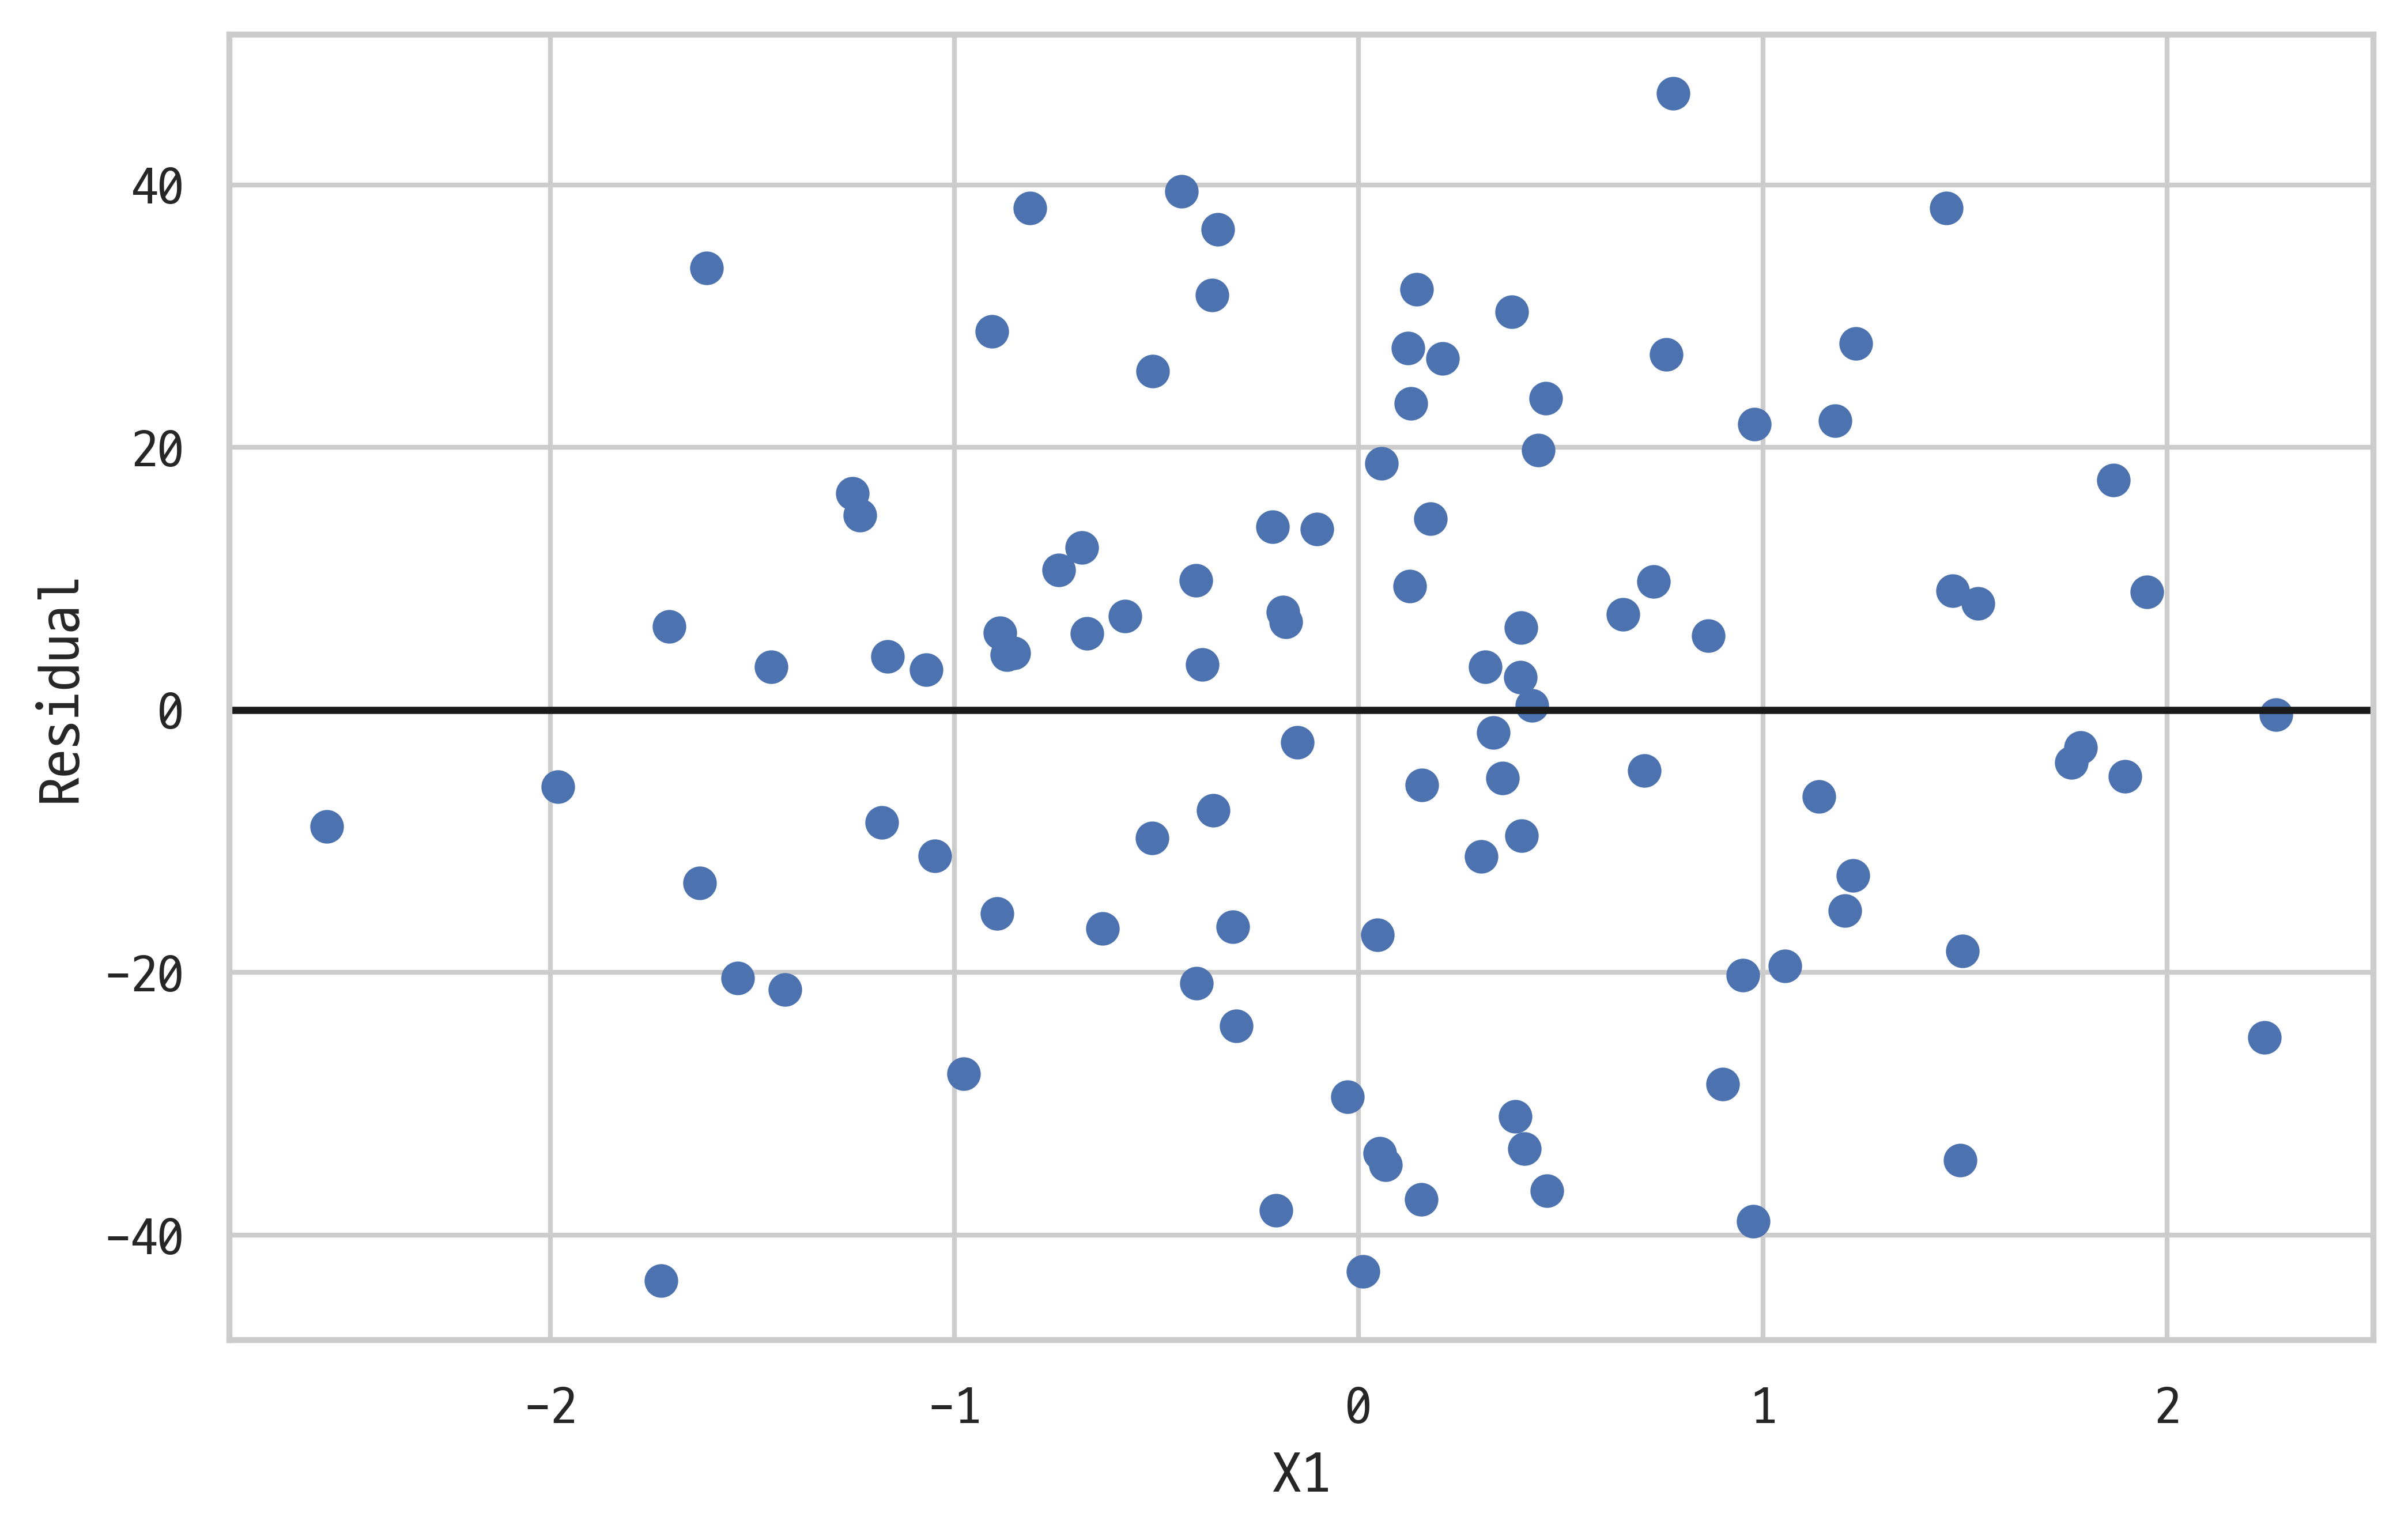

In [20]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel('X1')
plt.ylabel('Residual')
plt.show()

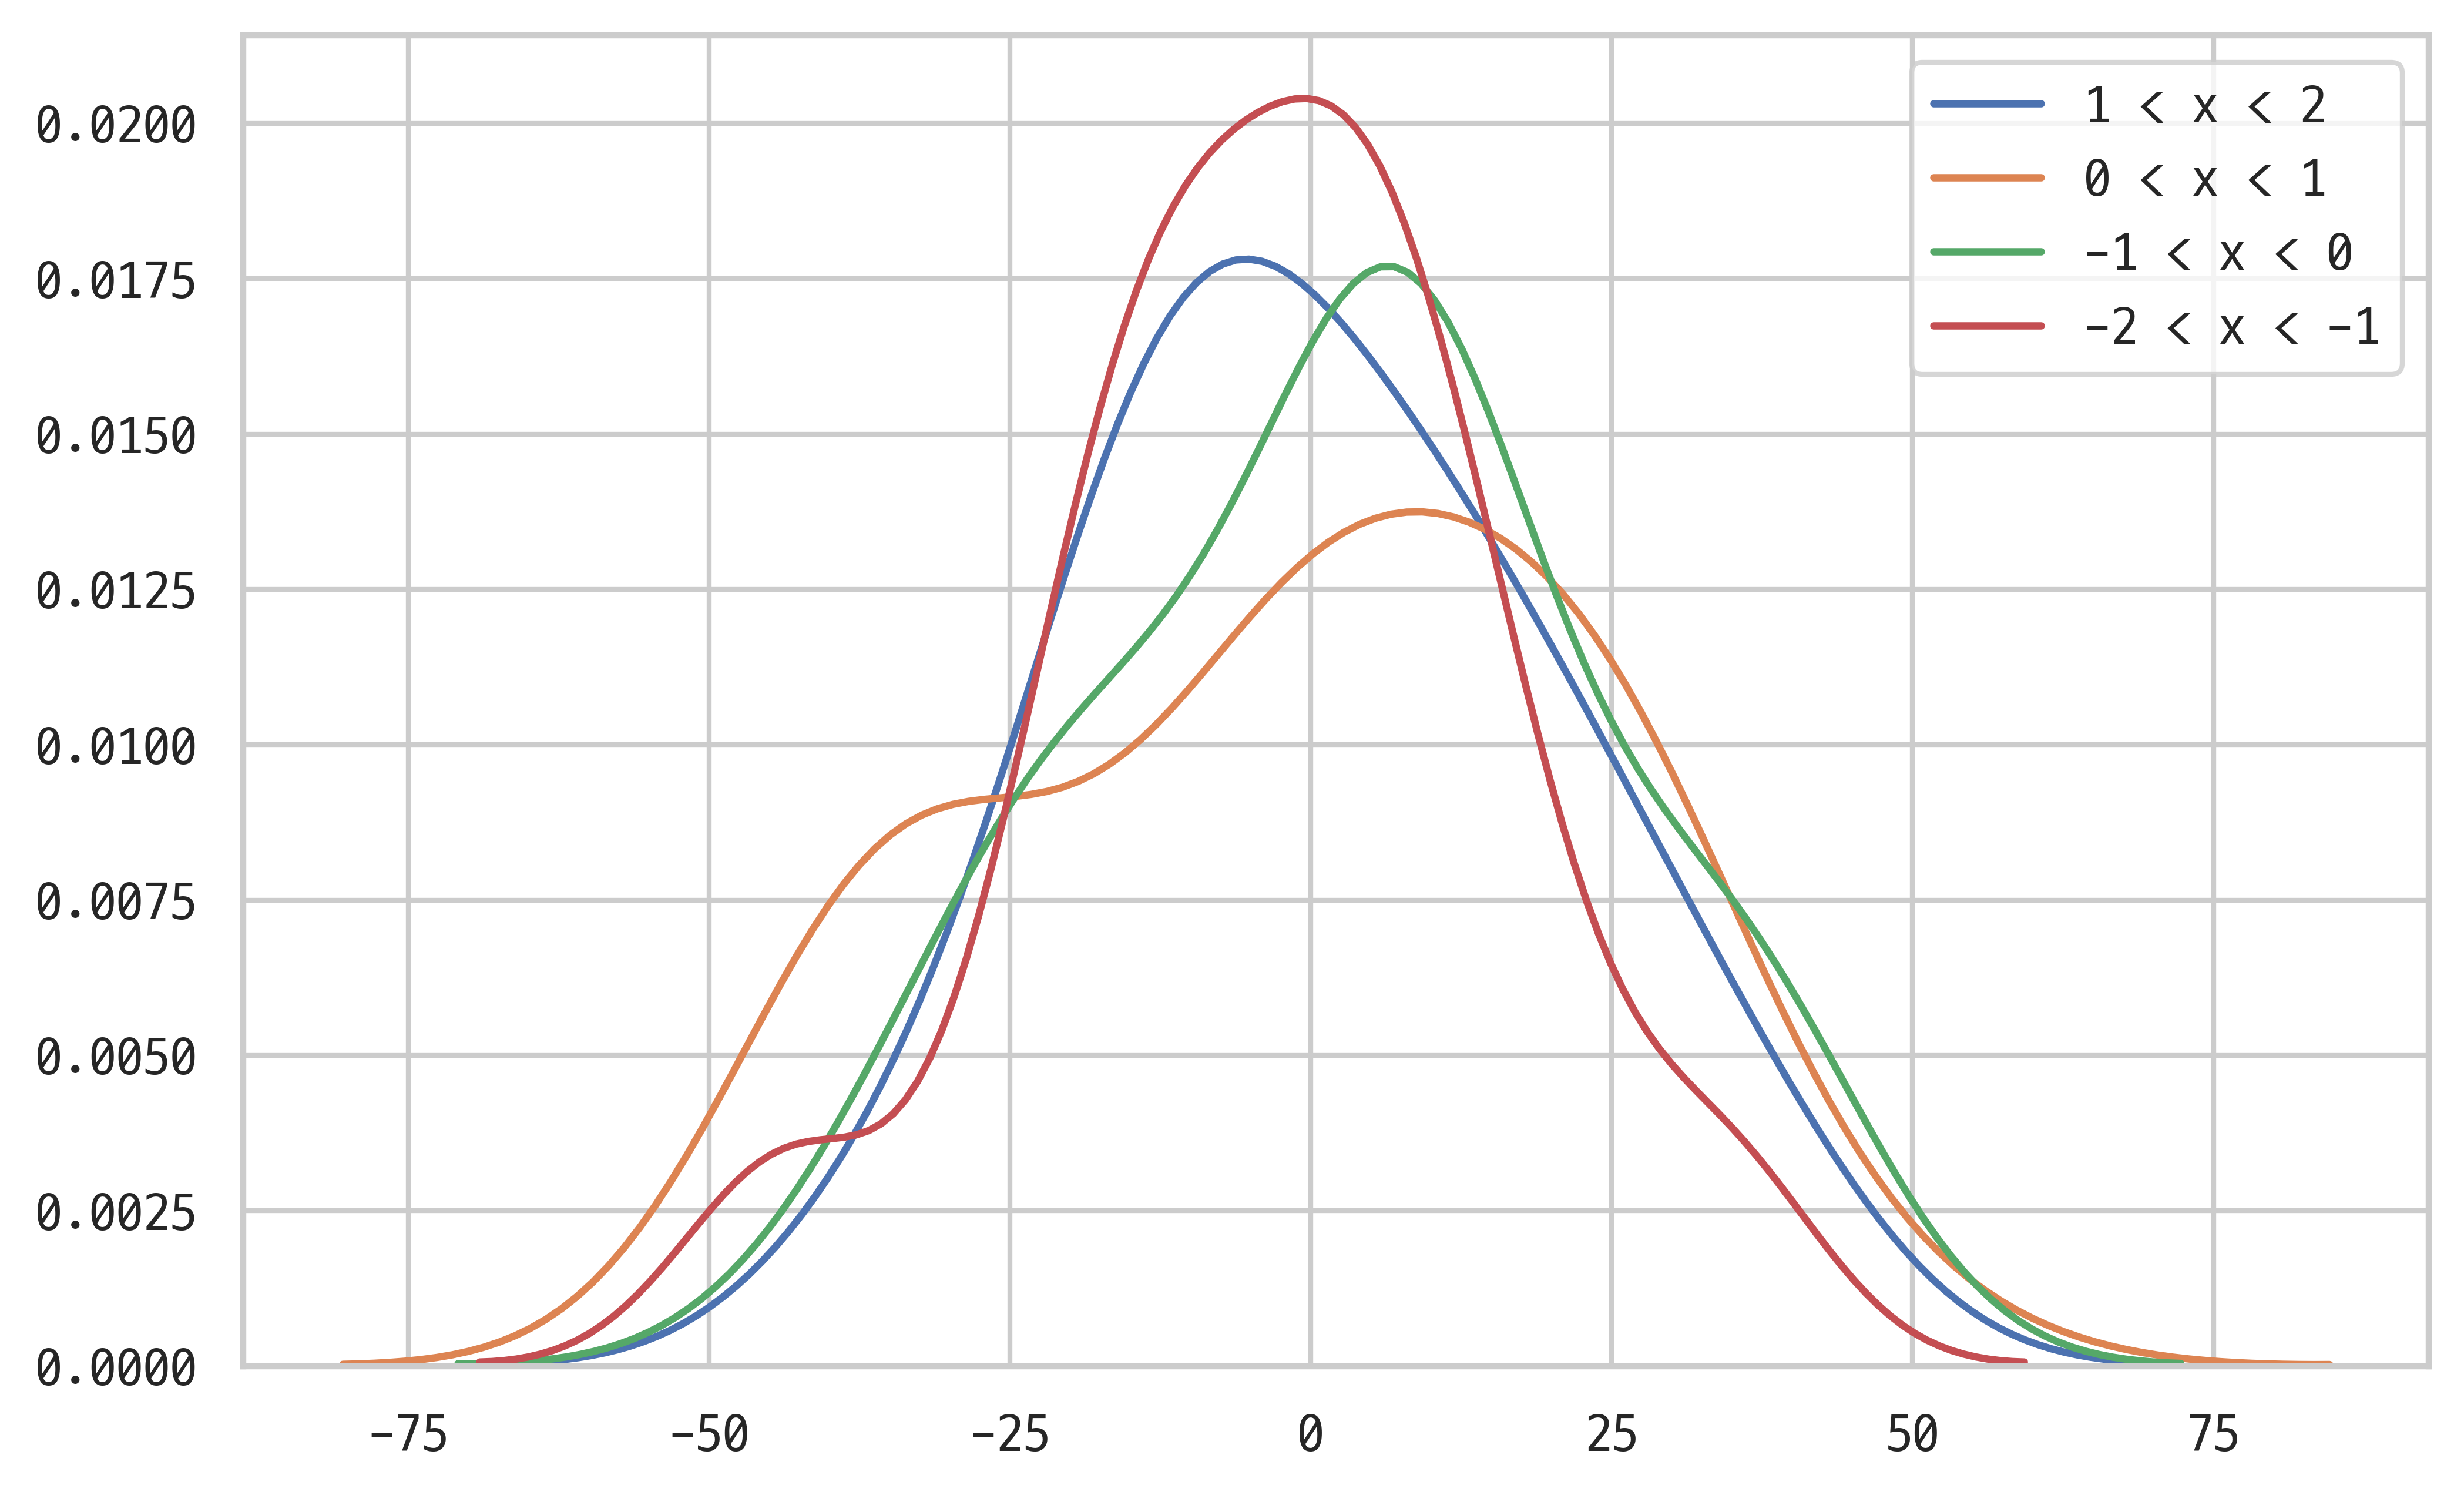

In [22]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label='1 < x < 2')
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label='0 < x < 1')
sns.kdeplot(result.resid[((-1 < X0) & (X0 < 0)).flatten()], label='-1 < x < 0')
sns.kdeplot(result.resid[((-2 < X0) & (X0 < -1)).flatten()], label='-2 < x < -1')
plt.legend()
plt.show()

#### 단일 계수 t-검정

In [23]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           2.21e-36
Time:                        19:33:13   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

In [24]:
print(result.t_test('X1 = 40'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


In [25]:
import datetime
from calendar import isleap

df_nottem = sm.datasets.get_rdataset('nottem').data

def convert_partial_year(number):
    """연 단위 숫자에서 날짜를 계산하는 코드"""
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

df_nottem['date0'] = df_nottem[['time']].applymap(convert_partial_year)
df_nottem['date'] = pd.DatetimeIndex(df_nottem['date0']).round('60min') + datetime.timedelta(seconds=3600*24)
df_nottem['month'] = df_nottem['date'].dt.strftime('%m').astype('category')
del df_nottem['date0'], df_nottem['date']

model_nottem = sm.OLS.from_formula("value ~ C(month) + 0", df_nottem)
result_nottem = model_nottem.fit()
print(result_nottem.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Mon, 26 Oct 2020   Prob (F-statistic):          2.96e-125
Time:                        19:36:27   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

In [26]:
print(result_nottem.t_test("C(month)[01] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5050      0.732      0.690      0.491      -0.937       1.947


In [28]:
print(result_nottem.t_test("C(month)[03] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             3.0050      0.732      4.105      0.000       1.563       4.447
